In [3]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

In [4]:
inputFile = 'preprocessed_data.csv'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

AttributeError: ignored

In [5]:
df = pd.read_csv(inputFile)
del df['FileName']
del df['timestamp']
target = df.loc[:,'INDOOR'].to_numpy()
del df['INDOOR']

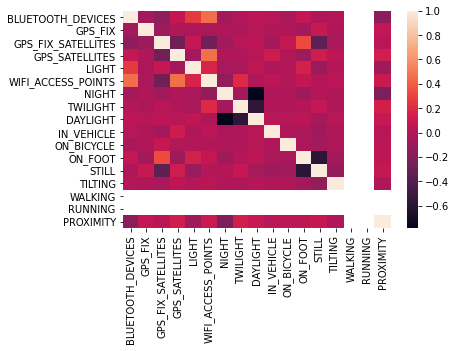

In [6]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr)

In [7]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.to_numpy(), target, test_size=0.33) 
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(22585, 17) (11124, 17) (22585,) (11124,)


In [8]:
D = X_train.shape[1]
D

17

In [11]:
# Now all the fun Tensorflow stuff
# Build the model

i = tf.keras.layers.Input(shape=(D,),name='Input')
x = tf.keras.layers.Dense(16,activation='sigmoid', name='Hidden')(i)
x = tf.keras.layers.Dense(1, activation='sigmoid', name='Classifier')(x)
model = tf.keras.models.Model(i, x)


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

r = model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs=200)

print("Train score:", model.evaluate(X_train, y_train))
print("Test score:", model.evaluate(X_test, y_test))


Epoch 1/200
706/706 [==============================] - 2s 2ms/step - loss: 0.6499 - accuracy: 0.6144 - val_loss: 0.5245 - val_accuracy: 0.7709
Epoch 2/200
706/706 [==============================] - 1s 2ms/step - loss: 0.5018 - accuracy: 0.7807 - val_loss: 0.4784 - val_accuracy: 0.7789
Epoch 3/200
706/706 [==============================] - 1s 2ms/step - loss: 0.4705 - accuracy: 0.7870 - val_loss: 0.4649 - val_accuracy: 0.7889
Epoch 4/200
706/706 [==============================] - 1s 2ms/step - loss: 0.4526 - accuracy: 0.8007 - val_loss: 0.4563 - val_accuracy: 0.7928
Epoch 5/200
706/706 [==============================] - 1s 2ms/step - loss: 0.4475 - accuracy: 0.8017 - val_loss: 0.4470 - val_accuracy: 0.8085
Epoch 6/200
706/706 [==============================] - 1s 2ms/step - loss: 0.4465 - accuracy: 0.8066 - val_loss: 0.4382 - val_accuracy: 0.8138
Epoch 7/200
706/706 [==============================] - 1s 2ms/step - loss: 0.4353 - accuracy: 0.8166 - val_loss: 0.4279 - val_accuracy: 0.8220

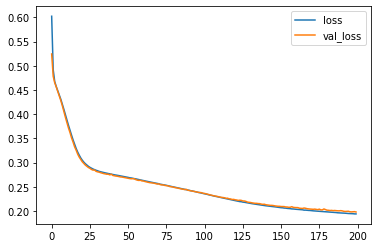

In [12]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

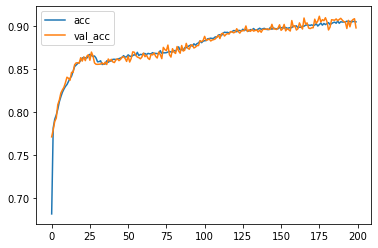

In [13]:
# Plot the accuracy too
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [14]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 17)]              0         
_________________________________________________________________
Hidden (Dense)               (None, 16)                288       
_________________________________________________________________
Classifier (Dense)           (None, 1)                 17        
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for z in zip(df_wide.columns.values,model.layers[5].get_weights()[0]):
  print(z)


('BLUETOOTH_DEVICES', array([0.78467166], dtype=float32))
('GPS_FIX_SATELLITES', array([-2.941558], dtype=float32))
('GPS_SATELLITES', array([0.3114541], dtype=float32))
('TMD3725_Light Ambient Light Sensor Non-wakeup', array([-0.46210802], dtype=float32))
('WIFI_ACCESS_POINTS', array([2.3207603], dtype=float32))
('IN_VEHICLE', array([-1.6584494], dtype=float32))
('ON_BICYCLE', array([-0.40118644], dtype=float32))
('ON_FOOT', array([-5.6376424], dtype=float32))
('STILL', array([1.7916169], dtype=float32))
('UNKOWN', array([1.2244202], dtype=float32))
('TILTING', array([0.3653815], dtype=float32))
('WALKING', array([-0.27648577], dtype=float32))
('RUNNING', array([0.12622678], dtype=float32))
('TMD3725_Proximity Proximity Sensor Wakeup', array([0.3069393], dtype=float32))


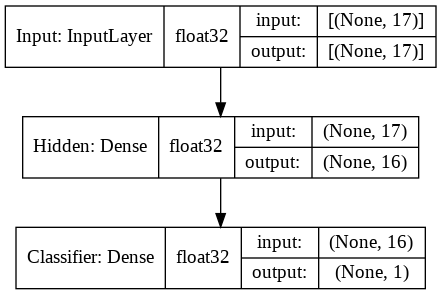

In [15]:
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True, show_layer_names=True, expand_nested=True)

In [19]:
!pip install tflite_support

     |████████████████████████████████| 1.1MB 1.9MB/s 
     |████████████████████████████████| 194kB 42.4MB/s 


In [20]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

In [22]:
# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "MobileNetV1 image classifier"
model_meta.description = ("Identify the most prominent object in the "
                          "image from a set of 1,001 categories such as "
                          "trees, animals, food, vehicles, person etc.")
model_meta.version = "v1"
model_meta.author = "TensorFlow"
model_meta.license = ("Apache License. Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")


In [23]:
# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()


In [24]:
input_meta.name = "feature_vector"
input_meta.description = (
    "Feature vector to be classified. The expected shape is {0} x {1}.".format(1, 17))
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.FeaturePropertiesT()
input_meta.content.contentProperties.shape = (1,17) 
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
input_normalization = _metadata_fb.ProcessUnitT
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.
input_normalization.options.mean = [127.5]
input_normalization.options.std = [127.5]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

SyntaxError: ignored

In [17]:
tf.saved_model.save(model, "saved_model_keras_dir")
"""
converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.allow_custom_ops=True
converter.experimental_new_converter =True
"""
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: saved_model_keras_dir/assets
INFO:tensorflow:Assets written to: /tmp/tmpxlwpf3t_/assets


In [ ]:
shap.summary_plot(shap_values[0], df_train)